# Оглавление

1. [Введение](#step1)
<br><br>
2. [Часть №1](#step2)
    - [ICE](#step4)
    - [RICE](#step5)
<br><br>
3. [Часть №2](#step3)
    - [График кумулятивной выручки по группам](#step6)
    - [График кумулятивного среднего чека по группам](#step7)
    - [График относительного изменения кумулятивного среднего чека](#step8)
    - [График кумулятивной конверсии по группам](#step9)
    - [График относительного изменения кумулятивной конверсии](#step10)
    - [Анализ количества заказов](#step11)
    - [Анализ стоимости заказов](#step12)
    - [Статистическая значимость различий в конверсии между группами по «сырым» данным](#step13)
    - [Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным](#step14)
    - [Статистическая значимость различий в конверсии между группами по «очищенным» данным](#step15)
    - [Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным](#step16)
<br><br>
4. [Вывод](#step17)

# Введение <a id="step1"></a>   

Данная работа разбита на две части. В первой будет проведена приоритизация гипотез двумя фреймворками: ICE и RICE. Проанализируем какие гипотезы окажутся в приоритете.  Во второй будет проведен анализ А/В теста, рассмотрено как аномальные данные повлияли на выводы, проведена проверка гипотез.

In [1]:
import pandas as pd
import seaborn as sns
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
pd.options.display.max_colwidth = -1

# Часть №1 <a id="step2"></a>   

In [2]:
hype = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')

## ICE <a id="step4"></a>   

$$ICE = \frac{Impact * Confidence}{Efforts}$$

In [3]:
hype['ICE'] = hype['Impact'] * hype['Confidence'] / hype['Efforts']

In [4]:
hype[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


## RICE <a id="step5"></a>   

In [5]:
hype['RICE'] = hype['Impact'] * hype['Confidence'] * hype['Reach'] / hype['Efforts']

In [6]:
hype[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Без учёта сложности гипотеза №8 имеет приоритет. Но учитывая затраты ресурсов на реализацию выберем гипотезы №7 и №2 для первоочередной првоерки

# Часть №2 <a id="step3"></a>   

In [7]:
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [8]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

## График кумулятивной выручки по группам <a id="step6"></a>   

In [9]:
datesGroups = orders[['date','group']].drop_duplicates() 

In [10]:
ordersAggregated = (datesGroups
                    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                    .agg({'date' : 'max', 
                          'group' : 'max', 
                          'transactionId' : pd.Series.nunique, 
                          'visitorId' : pd.Series.nunique, 
                          'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group']))

In [11]:
visitorsAggregated = (datesGroups
                      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                      .agg({'date' : 'max', 
                            'group' : 'max', 
                            'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group']))

In [12]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [13]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

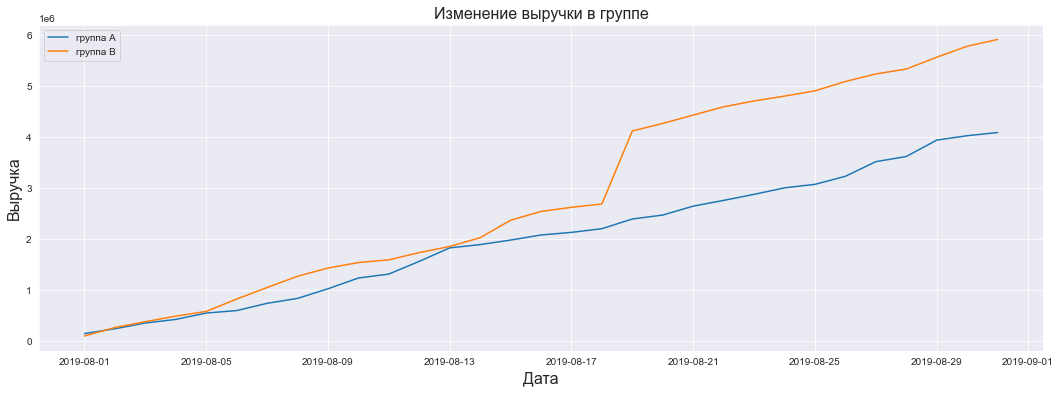

In [14]:
plt.figure(figsize=(18,6))
ax = sns.lineplot(data=cumulativeRevenueA, x='date', y='revenue')
sns.lineplot(data=cumulativeRevenueB, x='date', y='revenue')
ax.set_title('Изменение выручки в группе', fontdict={'fontsize': 16})
ax.set_xlabel('Дата', fontdict={'fontsize': 16})
ax.set_ylabel('Выручка', fontdict={'fontsize': 16})
ax.legend(['группа А', 'группа В']);

Выручка растет на протяжении всего эксперимента. Выручка группы В практически всегда выше чем в группе А. В группе В есть резкий рост. Возможно он обусловлен всплеском числа заказов или очень дорогим заказом.

## График кумулятивного среднего чека по группам <a id="step7"></a>   

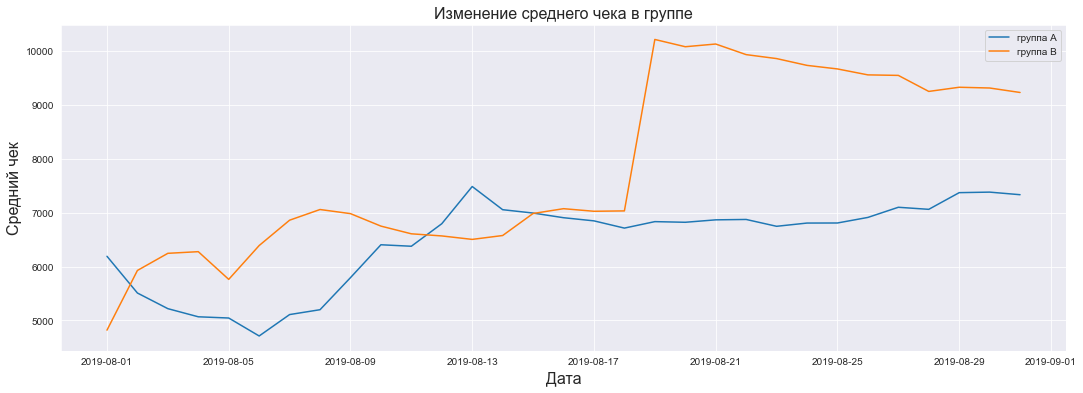

In [15]:
plt.figure(figsize=(18,6))
ax = sns.lineplot(data=cumulativeRevenueA, x='date', y=cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'])
sns.lineplot(data=cumulativeRevenueB, x='date', y=cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'])
ax.set_title('Изменение среднего чека в группе', fontdict={'fontsize': 16})
ax.set_xlabel('Дата', fontdict={'fontsize': 16})
ax.set_ylabel('Средний чек', fontdict={'fontsize': 16})
ax.legend(['группа А', 'группа В']);

Средний чек в группе В практически всегда был выше на прояжении эксперимента. Также видим выброс в группе В, что наводит на мысль о крупном заказе который резко увеличил средний чек. На данном тапе сложно делать выводы о том, что средний чек в группе В больше. Нужно смотреть отфильтрованные данные.

## График относительного изменения кумулятивного среднего чека <a id="step8"></a>   

In [16]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

In [17]:
mergedCumulativeRevenue['diff'] = ((mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
                                    /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

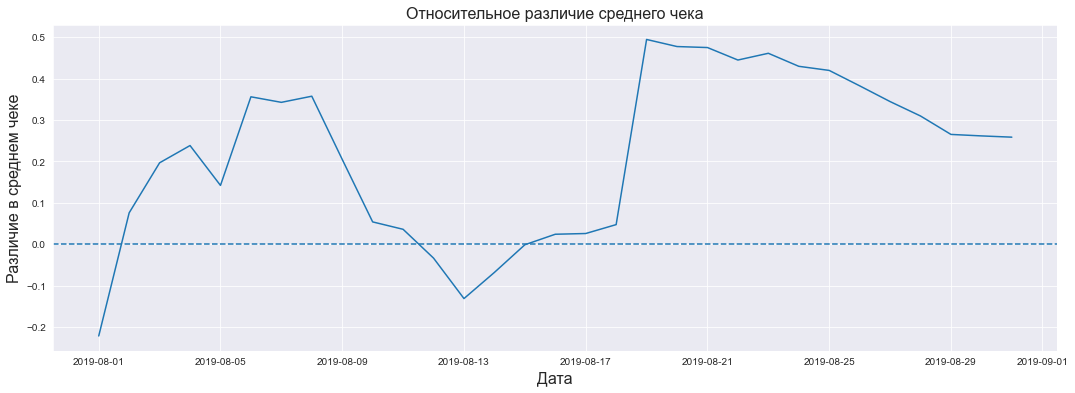

In [18]:
plt.figure(figsize=(18,6))
ax = sns.lineplot(data=mergedCumulativeRevenue, x='date', y='diff')
ax.set_title('Относительное различие среднего чека', fontdict={'fontsize': 16})
ax.set_xlabel('Дата', fontdict={'fontsize': 16})
ax.set_ylabel('Различие в среднем чеке', fontdict={'fontsize': 16})
ax.axhline(0, ls='--');

Также видны выбросы которые обусловлены аномальными заказами.

## График кумулятивной конверсии по группам <a id="step9"></a>   

In [19]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

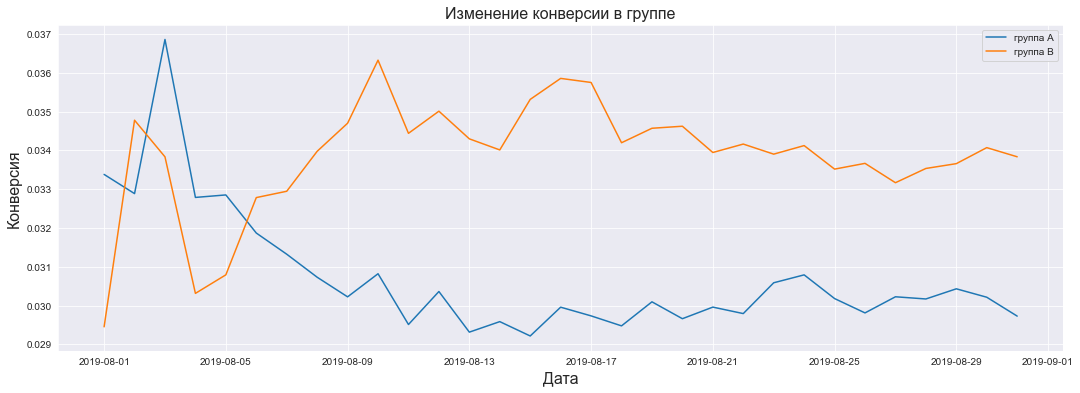

In [20]:
plt.figure(figsize=(18,6))
ax = sns.lineplot(data=cumulativeDataA, x='date', y='conversion')
sns.lineplot(data=cumulativeDataB, x='date', y='conversion')
ax.set_title('Изменение конверсии в группе', fontdict={'fontsize': 16})
ax.set_xlabel('Дата', fontdict={'fontsize': 16})
ax.set_ylabel('Конверсия', fontdict={'fontsize': 16})
ax.legend(['группа А', 'группа В']);

На этом графике достаточно очевидно разделились конверсии в группах. Нет аномальных выбросов. Конверсия в группе В очевидно выше.

##  График относительного изменения кумулятивной конверсии <a id="step10"></a>   

In [21]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                                           left_on='date', right_on='date', how='left', 
                                                                           suffixes=['A', 'B'])

In [22]:
mergedCumulativeConversions['diff'] = mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA'] - 1

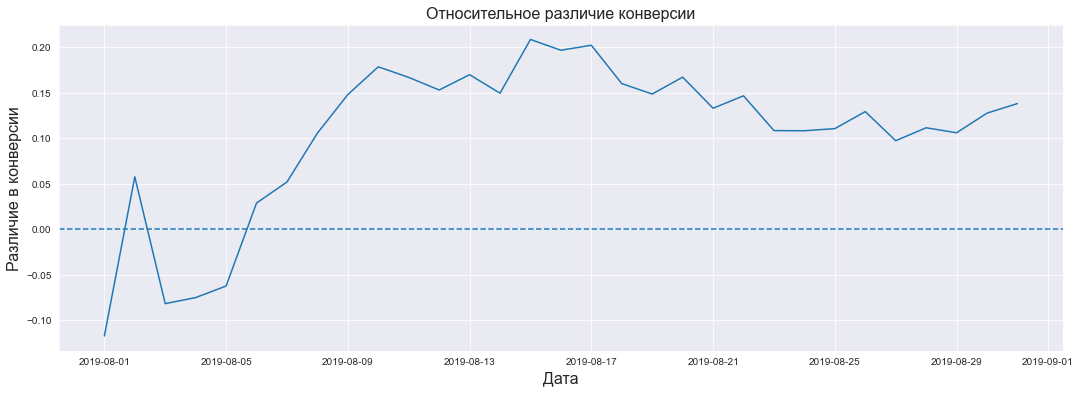

In [23]:
plt.figure(figsize=(18,6))
ax = sns.lineplot(data=mergedCumulativeConversions, x='date', y='diff')
ax.set_title('Относительное различие конверсии', fontdict={'fontsize': 16})
ax.set_xlabel('Дата', fontdict={'fontsize': 16})
ax.set_ylabel('Различие в конверсии', fontdict={'fontsize': 16})
ax.axhline(0, ls='--');

Этот график подтверждает тренд. После начального периода различие в конверсии зафиксировалось практически на одном уровне.

## Анализ количества заказов <a id="step11"></a>   

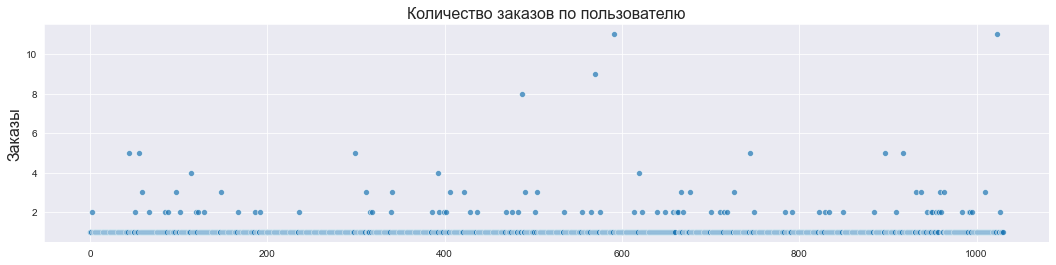

In [24]:
plt.figure(figsize=(18,4))
ordersByUsers = orders.groupby('visitorId').agg({'transactionId' : 'count'}).reset_index()
x_values = pd.Series(range(0,len(ordersByUsers['transactionId'])))
ax = sns.scatterplot(x_values, ordersByUsers['transactionId'], alpha=0.7) 
ax.set_title('Количество заказов по пользователю', fontdict={'fontsize': 16})
ax.set_ylabel('Заказы', fontdict={'fontsize': 16});

In [25]:
print(np.percentile(ordersByUsers['transactionId'], [90, 95, 99]))

[1. 2. 4.]


95% пользователей сделали не больше двух заказов. Именно пользователей с большим количеством заказов будем считать аномальными.

## Анализ стоимости заказов <a id="step12"></a>   

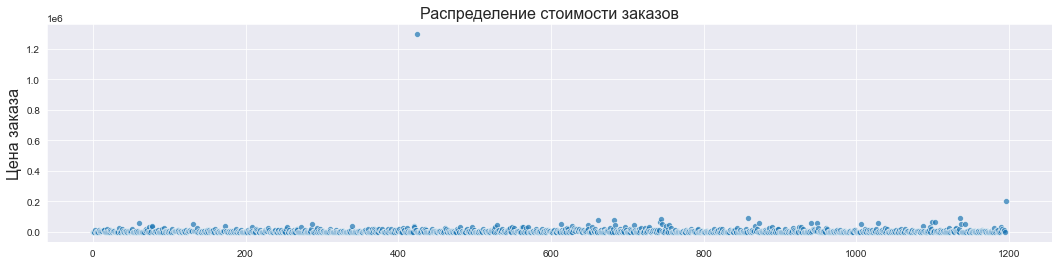

In [26]:
plt.figure(figsize=(18,4))
x_values = pd.Series(range(0,len(orders['revenue'])))
ax = sns.scatterplot(x_values, orders['revenue'], alpha=0.7) 
ax.set_title('Распределение стоимости заказов', fontdict={'fontsize': 16})
ax.set_ylabel('Цена заказа', fontdict={'fontsize': 16});

In [27]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[18168.  28000.  58233.2]


95% пользователей сделали заказ меньше 28000. Но по графику видно что подавляющая часть заказов находится ниже 20000. Именно эту цену заказа будем использовать в качестве порога отсечения аномальных заказов.

##  Статистическая значимость различий в конверсии между группами по «сырым» данным <a id="step13"></a>   

In [28]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

In [29]:
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].
                                            agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [30]:
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [31]:
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]
                                            .agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [32]:
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

In [33]:
ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

In [34]:
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [35]:
ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [36]:
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

In [37]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders'] 

In [38]:
sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), 
                               name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), 
                               name='orders')],axis=0) 

Определяем статистическую значимость в **0.05**. <br>
Формулируем гипотезы: <br>
**Н0** - статистически значимых различий в конверсии между группами А и В нет<br>
**H1** - конверсии в группах А и В отличаются

In [39]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

0.008
0.138


p-value оказалось равно 0.008. Что меньше статистической значимости, а значит у нас нет оснований принять нулевую гипотезу. Разница в конверсиях оказалась статистически значима. Выигрышь группы В составил 14%.

## Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным <a id="step14"></a>   

Определяем статистическую значимость в **0.05**. <br>
Формулируем гипотезы:<br>
**Н0** - статистически значимых различий в среднем чеке между группами А и В нет<br>
**H1** - средний чек в группах А и В различен

In [40]:
print("{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.365
0.259


p-value оказалось равно 0.365. Что больше статистической значимости, а значит у нас нет оснований отвергнуть нулевую гипотезу. Разница в среднем чеке оказалась статистически незначима. Выигрышь группы В составил 26%.

## Статистическая значимость различий в конверсии между группами по «очищенным» данным <a id="step15"></a>   

In [41]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], 
                                 ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 20000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

In [42]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                                       name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                                       name='orders')],axis=0) 

Определяем статистическую значимость в **0.05**.<br>
Формулируем гипотезы:<br>
**Н0** - статистически значимых различий в конверсии между группами А и В нет <br>
**H1** - конверсия в группах А и В различна

In [43]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.009
0.170


p-value оказалось равно 0.009. Что меньше статистической значимости, а значит у нас нет оснований принять нулевую гипотезу. Разница в конверсиях оказалась статистически значима с учетом фильтрации данных. Относительный выигрышь группы В оказался 17%.

In [44]:
ordersAggregatedFiltered = (datesGroups
                    .apply(lambda x: orders[np.logical_and(np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                        np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group']))]
                    .agg({'date' : 'max', 
                          'group' : 'max', 
                          'transactionId' : pd.Series.nunique, 
                          'visitorId' : pd.Series.nunique, 
                          'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group'])).reset_index().drop('index', axis=1)

In [45]:
cumulativeDataFiltered = ordersAggregatedFiltered.merge(visitorsAggregated, 
                                                        left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeDataFiltered.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [46]:
# считаем кумулятивную конверсию
cumulativeDataFiltered['conversion'] = cumulativeDataFiltered['orders']/cumulativeDataFiltered['visitors']

# отделяем данные по группе A
cumulativeDataFilteredA = cumulativeDataFiltered[cumulativeDataFiltered['group']=='A']

# отделяем данные по группе B
cumulativeDataFilteredB = cumulativeDataFiltered[cumulativeDataFiltered['group']=='B']

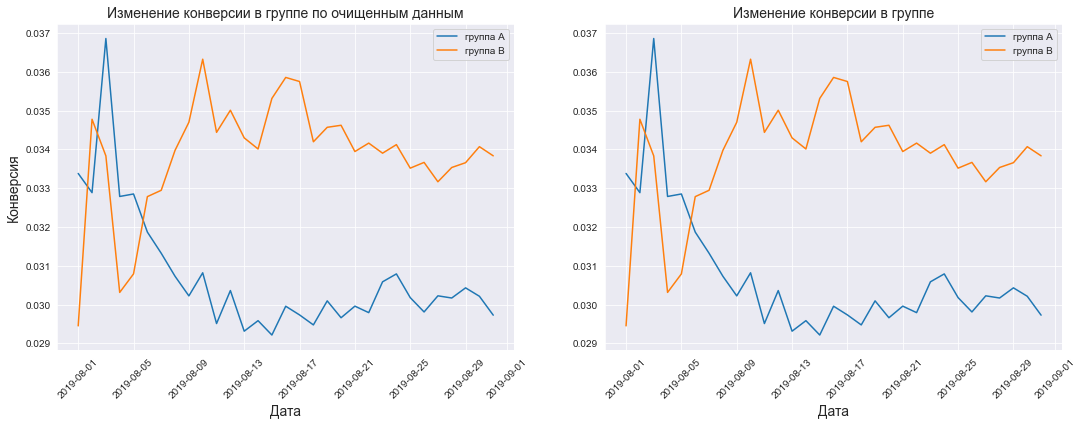

In [47]:
plt.figure(figsize=(18,6))
ax1 = plt.subplot(121)
ax1 = sns.lineplot(data=cumulativeDataA, x='date', y='conversion')
sns.lineplot(data=cumulativeDataB, x='date', y='conversion')
ax1.set_title('Изменение конверсии в группе по очищенным данным', fontdict={'fontsize': 14})
ax1.set_xlabel('Дата', fontdict={'fontsize': 14})
ax1.set_ylabel('Конверсия', fontdict={'fontsize': 14})
ax1.legend(['группа А', 'группа В'])
plt.xticks(rotation=45)
ax2 = plt.subplot(122)
ax2 = sns.lineplot(data=cumulativeDataA, x='date', y='conversion')
sns.lineplot(data=cumulativeDataB, x='date', y='conversion')
ax2.set_title('Изменение конверсии в группе', fontdict={'fontsize': 14})
ax2.set_xlabel('Дата', fontdict={'fontsize': 14})
ax2.set_ylabel('')
ax2.legend(['группа А', 'группа В'])
plt.xticks(rotation=45);

График конверсий не изменился после фильтрации данных.

##  Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным <a id="step16"></a>   

Определяем статистическую значимость в **0.05**.<br>
Формулируем гипотезы:<br>
**Н0** - статистически значимых различий в среднем чеке между группами А и В нет<br>
**H1** - средний чек в групаах А и В отличается

In [48]:
print("{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

0.349
-0.030


p-value оказалось равно 0.349. Что больше статистической значимости, а значит у нас нет оснований отвергнуть нулевую гипотезу. Разница в среднем чеке оказалась статистически незначима, даже с учетом удаления аномальных заказов. Относительный проигрышь группы В составил 3%.

In [49]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueFilteredA = cumulativeDataFiltered[cumulativeDataFiltered['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueFilteredB = cumulativeDataFiltered[cumulativeDataFiltered['group']=='B'][['date','revenue', 'orders']]

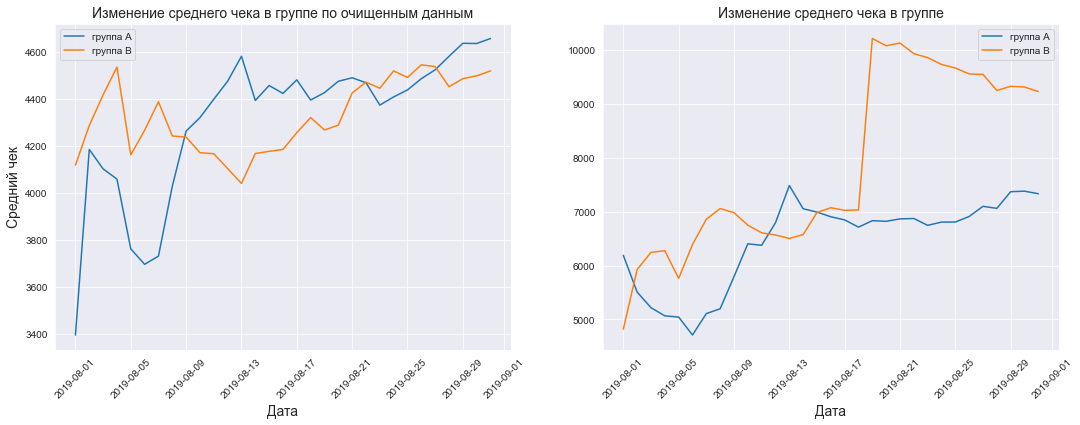

In [50]:
plt.figure(figsize=(18,6))
ax1 = plt.subplot(121)
ax1 = sns.lineplot(data=cumulativeRevenueFilteredA, x='date', 
                  y=cumulativeRevenueFilteredA['revenue']/cumulativeRevenueFilteredA['orders'])
sns.lineplot(data=cumulativeRevenueFilteredB, x='date', 
             y=cumulativeRevenueFilteredB['revenue']/cumulativeRevenueFilteredB['orders'])
ax1.set_title('Изменение среднего чека в группе по очищенным данным', fontdict={'fontsize': 14})
ax1.set_xlabel('Дата', fontdict={'fontsize': 14})
ax1.set_ylabel('Средний чек', fontdict={'fontsize': 14})
ax1.legend(['группа А', 'группа В'])
plt.xticks(rotation=45)
ax2 = plt.subplot(122)
ax2 = sns.lineplot(data=cumulativeRevenueA, x='date', y=cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'])
sns.lineplot(data=cumulativeRevenueB, x='date', y=cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'])
ax2.set_title('Изменение среднего чека в группе', fontdict={'fontsize': 14})
ax2.set_xlabel('Дата', fontdict={'fontsize': 14})
ax2.set_ylabel('')
ax2.legend(['группа А', 'группа В'])
plt.xticks(rotation=45);

График изменился. Выпал аномальный заказ который визуально делал средний чек больше, в группе В.

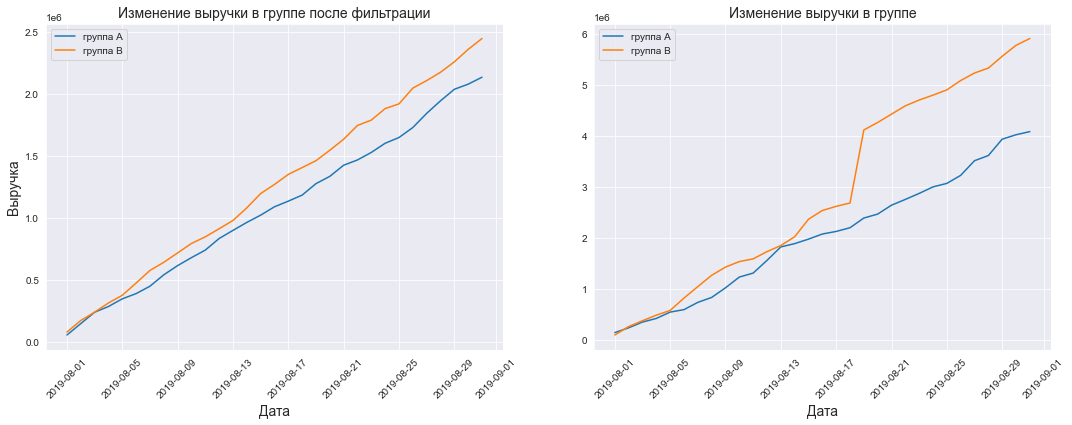

In [51]:
plt.figure(figsize=(18,6))
ax1 = plt.subplot(121)
ax1 = sns.lineplot(data=cumulativeRevenueFilteredA, x='date', y='revenue')
sns.lineplot(data=cumulativeRevenueFilteredB, x='date', y='revenue')
ax1.set_title('Изменение выручки в группе после фильтрации', fontdict={'fontsize': 14})
ax1.set_xlabel('Дата', fontdict={'fontsize': 14})
ax1.set_ylabel('Выручка', fontdict={'fontsize': 14})
ax1.legend(['группа А', 'группа В'])
plt.xticks(rotation=45)
ax2 = plt.subplot(122)
ax2 = sns.lineplot(data=cumulativeRevenueA, x='date', y='revenue')
sns.lineplot(data=cumulativeRevenueB, x='date', y='revenue')
ax2.set_title('Изменение выручки в группе', fontdict={'fontsize': 14})
ax2.set_xlabel('Дата', fontdict={'fontsize': 14})
ax2.set_ylabel('')
ax2.legend(['группа А', 'группа В'])
plt.xticks(rotation=45);

# Вывод <a id="step17"></a>  

**Часть №1**<br>
Видно как учет затрат на ввод той или иной стратегии влияет на приоритет гипотез. Если учитывать гипотезы в некотормо ваакууме, то акция скидки в день рождения (гипотеза №8) приобритает наибольший приоритет. Но ресурсы всегда орграничены и учитывая их уже добавление формы (гипотеза №7) оказывается предпочтительнее.<br>
**Часть №2**<br>
На сравнительном графике выручки видно, что группа В на 4 день эксперимента выходит вперед и стабильно растет быстрее чем в группе А. По анализу видно, что средний чек в группах не отличается. График до фильтрации исказил один аномальный заказ. Который, впрочем, не внёс ошибки в тест. p-value до и после филтрации практически не изменились. Конверсия же в группах различна, и именно она объясняет рост выручки в группе В. На основании проведенного анализа я бы сказал, что изменения которые мы применили для группы В могут увеличить конверсию, а следом и всю выручку компании.